In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import sys; sys.path.insert(0,'..')
from main import *

In [2]:
X, y = load_svmlight_file('../data/phishing/phishing.txt')
X = X.toarray()

# Convert labels from {0, 1} to {-1, 1}
y = y * 2 - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, stratify=y, 
                                                    shuffle=True, random_state=1)

In [ ]:
svm_arr, tree_arr = data_size_experiment(X_train, y_train, X_test, y_test,
                                         rank=True, rounded=True, plots_or_table='plots',
                                         random_state=1, verbose=True)

In [2]:
svm_arr = np.load('temp_arrays/phishing_svm.npy')
tree_arr = np.load('temp_arrays/phishing_tree.npy')

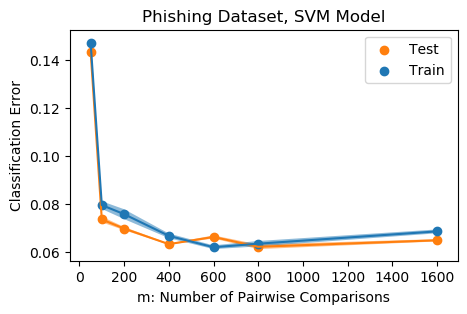

In [3]:
plot_err(svm_arr, 'Phishing', 'SVM', scale=1, save=True)

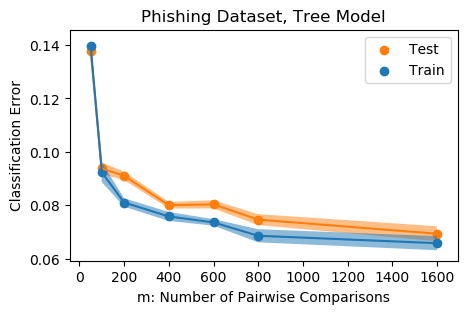

In [4]:
plot_err(tree_arr, 'Phishing', 'Tree', scale=1, save=True)

In [ ]:
# np.save('temp_arrays/phishing_svm', svm_arr)
# np.save('temp_arrays/phishing_tree', tree_arr)

# SU Compare

In [3]:
from su_learning import SU_DH as SU
from su_learning import convert_su_data_sklearn_compatible

n_s = 500
n_u = 500

# Sizes of sets to sample similar and unlabeled points
train_size = 5000
su_cutoff  = 2500

# Only use some of training data
train_samples = np.random.permutation(X_train.shape[0])[:train_size]
X_train = X_train[train_samples]
y_train = y_train[train_samples]

# Sample similar and unlabeled points from disjoint sets
X_s_set = X_train[:su_cutoff]
y_s_set = y_train[:su_cutoff]
X_u_set = X_train[su_cutoff:]
y_u_set = y_train[su_cutoff:]

# Get positive similar pairs and negative similar pairs
X_pos = X_s_set[np.where(y_s_set ==  1)]
X_neg = X_s_set[np.where(y_s_set == -1)]

X_pos_idx = np.random.choice(X_pos.shape[0], size=(int(n_s / 2), 2))
X_neg_idx = np.random.choice(X_neg.shape[0], size=(int(n_s / 2), 2))

# Fill in similar pairs
X_s = np.full((n_s, X_train.shape[1] * 2), np.NaN)

k = 0
for (i, j) in X_pos_idx:
    X_s[k] = np.hstack((X_pos[i], X_pos[j]))
    k += 1
    
for (i, j) in X_neg_idx:
    X_s[k] =np.hstack((X_neg[i], X_neg[j]))
    k += 1

# Fill in unlabeled data
unlabeled_samples = np.random.permutation(X_u_set.shape[0])[:n_u]
X_u = X_u_set[unlabeled_samples]

# Convert to format to train SU classifier
X_train, y_train = convert_su_data_sklearn_compatible(X_s, X_u)

In [12]:
%%time
clf = SU(prior=0.7, lam=0.1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
accuracy_score(y_train, y_pred), (y_pred == 1).all(), (y_pred == -1).all()

(0.6666666666666666, True, False)